In [28]:
import pandas as pd
import numpy as np

import sklearn
from sklearn import preprocessing, linear_model, model_selection
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns

# Gross Prediction Model
In this notebook we will try to create a machine learning model that will try to predict the gross of a movie by it's features

## Loading the dataframe
We will load our final dataframe and perform some cleaning and manipulation to it so it can be fed to the algorithm

In [3]:
df = pd.read_csv("./output_data/final_table.csv")
df = df.drop("Unnamed: 0",axis=1)

## Cleaning the Dataframe
We want to have only the relevant columns for our prediction model. We'll drop the id, movie name and links, we'll also drop the gross and tickets columns to later sum it up

In [4]:
df_cleaned = df[["runtime","day","month","year","genres","dist"]]
df_cleaned[["day","year","month"]]=df_cleaned[["day","year","month"]].replace(0,np.nan)
df_cleaned.loc["gross"]=np.nan
df_cleaned.loc["tickets"]=np.nan

D:\anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
D:\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## Summing Gross and Tickets along all years
We want to each movie have a total gross and tickets sold so we would know our future profit undependent on years

In [5]:
def createYearsPrefixArray(prefix:str,start:int,end:int):
    arr=[]
    for i in range(start,end+1):
        arr.append(f"{prefix}{i}")
    return arr

gross_list = createYearsPrefixArray("gross_",1995,2020)
tickets_list = createYearsPrefixArray("tickets_",1995,2020)

for index, row in df.iterrows():
    df_cleaned.loc[index,"gross"] = df.iloc[index][gross_list].sum()
    df_cleaned.loc[index,"tickets"] = df.iloc[index][tickets_list].sum()

D:\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
D:\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


## Cleaning rows with nan
We have 10854 rows that have semi missing values. We will drop all rows with nans and continue to create a prediction model

In [6]:
print("With nans:",df_cleaned.shape[0])
df_cleaned = df_cleaned.dropna()
print("Without nans:",df_cleaned.shape[0])

With nans: 10854
Without nans: 10127


## Converting Unique Strings to Categorical Values
Next thing to do is convert genres and dist fields to unique numbered keys for our ML model to understand

In [7]:
df_cleaned["genres"] = pd.Categorical(df_cleaned["genres"]).codes
df_cleaned["dist"] = pd.Categorical(df_cleaned["dist"]).codes

## Feature-Label and Test-Train Division 
We will divide our cleaned dataframe to label dataframe that holds the gross and tickets columns and feature dataframe for the rest

In [8]:
features_df = df_cleaned[["runtime","day","month","year","genres","dist"]]
labels_df = df_cleaned[["gross","tickets"]]

In [9]:
features_Train ,features_Test,labels_Train,labels_Test = train_test_split(features_df,labels_df,test_size=0.3,random_state=0)

In [10]:
train_set = (features_Train,labels_Train)
test_set = (features_Test,labels_Test)

## Scaling the sets:
We will use a MinMaxScaler to scale our data.

In [11]:
scaler = MinMaxScaler()
def minMaxScaleSet(dataset,scaler):
    features,labels = dataset
    return scaler.fit_transform(features),scaler.fit_transform(labels)


In [12]:
train_set_scaled = minMaxScaleSet(train_set,scaler)
test_set_scaled = minMaxScaleSet(test_set,scaler)

## KNN Regression Model
We will use the K-nearest neighbors algorithm to try to predict the gross and tickets for a given environment since there really isn't a "pattern" in said conditions and we'll try to avarage our results based on prior knowledge


In [13]:
model = KNeighborsRegressor()
model.fit(*train_set_scaled)
prediction = model.predict(test_set_scaled[0])

We will now compare the results in a dataframe that has columns for the ground truth, prediction and the error

In [17]:
test_results = pd.DataFrame(test_set_scaled[1])
test_results.columns=["gross_truth","tickets_truth"]
test_results[["gross_prediction","tickets_prediction"]] = prediction
test_results["gross_error"] = test_results["gross_truth"]-test_results["gross_prediction"]
test_results["tickets_error"] = test_results["tickets_truth"]-test_results["tickets_prediction"]

In [51]:
test_results

,gross_truth,tickets_truth,gross_prediction,tickets_prediction,gross_error,tickets_error
0,0.004607,0.006171,0.046519,0.046842,-0.041912,-0.040671
1,0.215178,0.206089,0.042089,0.032567,0.173090,0.173522
2,0.000032,0.000040,0.006588,0.008747,-0.006556,-0.008706
3,0.000303,0.000489,0.009443,0.010813,-0.009141,-0.010324
4,0.000828,0.000839,0.000500,0.000399,0.000328,0.000440
...,...,...,...,...,...,...
3034,0.001038,0.001080,0.038130,0.030362,-0.037093,-0.029282
3035,0.000001,0.000001,0.030677,0.023153,-0.030675,-0.023151
3036,0.000020,0.000020,0.000216,0.000166,-0.000196,-0.000146
3037,0.000142,0.000173,0.026781,0.027424,-0.026640,-0.027250


## Plotting the error
We would like to plot both gross and tickets error and see if we can learn something

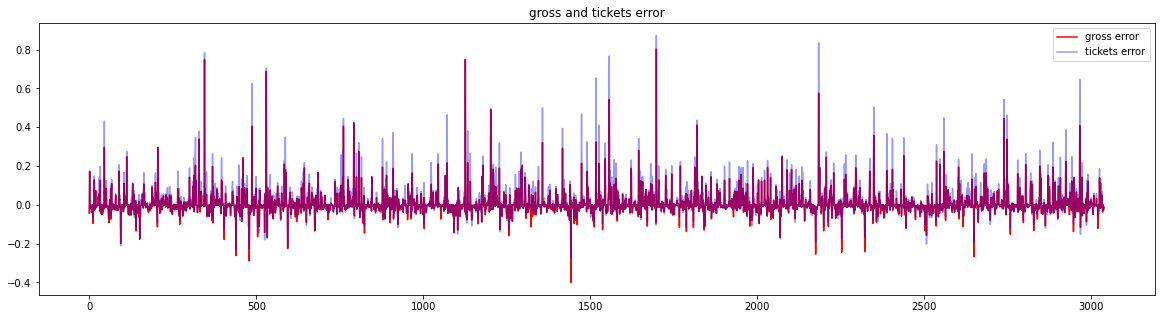

In [55]:
plt.figure(figsize=(20,5))
plt.title("gross and tickets error")
plt.plot(test_results["gross_error"],color="red")
plt.plot(test_results["tickets_error"],color="blue",alpha=0.4)
plt.legend(["gross error","tickets error"])


## Further Examination
At first it seems that the graph is really fuzzy and there is a really big error, but we are dealing with continious values. We'll plot a histogram and see where the values fall

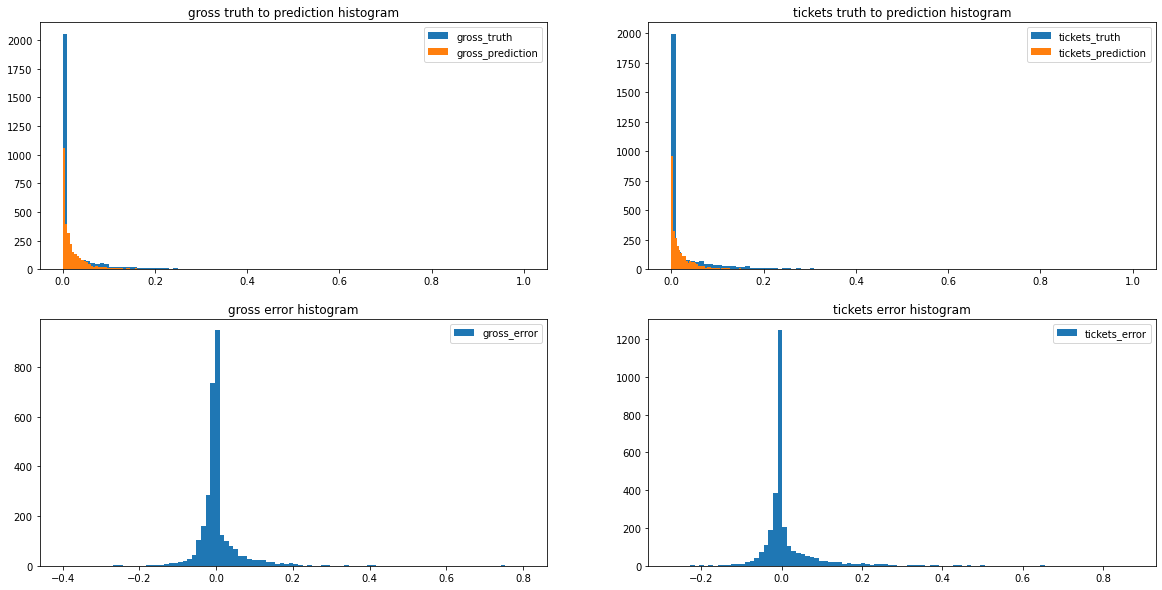

In [63]:

def plot_at(ax,index:tuple,dataset,columns,title,bins=100):
    ax[index].title.set_text(title)
    for col in columns:
        ax[index].hist(dataset[col],bins=bins)
    ax[index].legend(columns)
fig,ax = plt.subplots(2,2,figsize=(20,10))
plot_at(ax,(0,0),test_results,["gross_truth","gross_prediction"],"gross truth to prediction histogram")
plot_at(ax,(0,1),test_results,["tickets_truth","tickets_prediction"],"tickets truth to prediction histogram")
plot_at(ax,(1,0),test_results,["gross_error"],"gross error histogram")
plot_at(ax,(1,1),test_results,["tickets_error"],"tickets error histogram")


## Conclusions
It seems that our model manages to predict correctly most of the values by the looks of the histograms. The gross and tickets error histograms calculate the subtraction of the ground truth to the predicted value which means - closer to 0 is better.